### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:82.5% !important}</style>'))

In [2]:
import time
import datetime

import numpy as np
import pandas as pd

import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, VotingClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Paths to directories and files

In [5]:
TRAIN_DATASET_PATH = 'train_dataset_hackathon_mkb.csv'
TEST_DATASET_PATH = 'test_dataset_hackathon_mkb.csv'

### Loading data

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, encoding='cp1251', delimiter=';') 
test_df = pd.read_csv(TEST_DATASET_PATH, encoding='cp1251', delimiter=';')
print(train_df.shape, test_df.shape)

(17891, 124) (7330, 123)


### Functions

In [7]:
def cross_validation(model, X, y, cv):
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model.fit(X=x_train, y=y_train)
    
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f'Training fold {fold+1}, Test score: {score:.5f}')
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f'Test mean score: {np.mean(folds_scores):.5f}')
    return estimators, oof_preds, np.mean(folds_scores)

In [8]:
# Функция преобразования категориальных данных
le = LabelEncoder()

def categorical_engineering(df):
    for i in categorical_features:
        le.fit(df[i])
        df[i] = le.fit_transform(df[i])

### Feature engineering 

In [9]:
# Поиск совпадающих строк тестовых и учебных данных по полю - 'id_client'
new_train_df = test_df.loc[(test_df['id_client'].isin(train_df['id_client']))]
print(new_train_df.shape)

(2476, 123)


In [10]:
# Удаление дублирующих строк
new_train_df = new_train_df.drop_duplicates(subset=['id_client'])
print(new_train_df.shape)

(948, 123)


In [11]:
target = train_df.loc[(train_df['id_client'].isin(new_train_df['id_client']))]

In [12]:
# Срез датафрейма с предсказаниями
target = target[['id_client', 'TARGET']].drop_duplicates(subset=['id_client'], keep='last')

In [13]:
# Объединение таблиц на основе ключа - 'id_client'
new_train_df = pd.merge(new_train_df, target, on='id_client', how='left')

In [14]:
# Конкатенация учебного датафрейма и тестовой выборки с предсказаниями
train_df = pd.concat([train_df, new_train_df])
print(train_df.shape)

(18839, 124)


In [15]:
# Сброс индексов
train_df.reset_index(drop=True, inplace=True)

In [16]:
TARGET = 'TARGET'
COLUMN_ID = 'id_contract'
test_index = test_df[COLUMN_ID]

In [17]:
def feature_engineering(df):
    # Уменьшение количества выбросов - удаление малозначимых/неинформативных признаков
    df.drop(['SIGN_DATE'], axis=1, inplace=True) # ↑
    df.drop(['CITIZENSHIP_NAME'], axis=1, inplace=True) # ↑
    df.drop(['SEX_NAME'], axis=1, inplace=True) # ↑ 
    df.drop(['F1410_LAG1'], axis=1, inplace=True) # ↑  
    
    # Дата регистрации
    df['DATEFIRSTREG'] = pd.to_datetime(df['DATEFIRSTREG'], format='%d%b%Y:%H:%M:%S') # ↑
    df['DATEFIRSTREG_YEAR'] = df['DATEFIRSTREG'].apply(lambda ts: ts.year).values # ↑
    df.loc[df['DATEFIRSTREG_YEAR'] == 2020, 'DATEFIRSTREG_YEAR'] = 2002 # ↑
    df.drop(['DATEFIRSTREG'], axis=1, inplace=True) # ←↑→

    # Регистрация в налоговом органе. Дата регистрации
    df['TAXREG_REGDATE'] = pd.to_datetime(df['TAXREG_REGDATE'], format='%d%b%Y:%H:%M:%S') # ↑
    df['TAXREG_REGDATE_YEAR'] = df['TAXREG_REGDATE'].apply(lambda ts: ts.year).values # ↑
    df.loc[df['TAXREG_REGDATE_YEAR'] == 2020, 'DATEFIRSTREG_YEAR'] = 2002 # ↑
    df.drop(['TAXREG_REGDATE'], axis=1, inplace=True) # ←↑→
    
    # Проверка временем
    df['TEST_OF_TIME'] = 0
    df.loc[((df['DATEFIRSTREG_YEAR'] >= 2016) & (df['TAXREG_REGDATE_YEAR'] >= 2016), 'TEST_OF_TIME')] = 1 # ↑
    
    # Сумма предыдущих контрактов
    df['THE_AMOUNT_OF_PREVIOUS_CONTRACTS'] = df['SUM_233_EVER'] + df['SUM_95_EVER'] # ↑ 
    
    # Заполнение пропусков значениями
    num_median = df['F2110'].median()
    df.loc[df['F2110'].isnull(), 'F2110'] = num_median # ↑
    
    # Преобразование из категориальной переменной в числовую
    df['OKVED_CODE'] = df['OKVED_CODE'].astype(float, errors='ignore') # 0.96656 - 0.8773 ←↑→
    df['OKVED_CODE_1'], df['OKVED_CODE_2'], df['OKVED_CODE_3'] = df['OKVED_CODE'].str.split('.').str
    df['OKVED_CODE_11'] = df['OKVED_CODE_1'].str[0:1]
    df['OKVED_CODE_12'] = df['OKVED_CODE_1'].str[1:2]
    df['OKVED_CODE_21'] = df['OKVED_CODE_2'].str[0:1]
    df['OKVED_CODE_22'] = df['OKVED_CODE_2'].str[1:2]
    df['OKVED_CODE_31'] = df['OKVED_CODE_3'].str[0:1]
    df.drop(['OKVED_CODE'], axis=1, inplace=True)
    df.drop(['OKVED_CODE_1'], axis=1, inplace=True)
    df.drop(['OKVED_CODE_2'], axis=1, inplace=True)
    df.drop(['OKVED_CODE_3'], axis=1, inplace=True)
    
    # Кумулятивное вычисление количества контрактов 
#     df['cum_count_client'] = df.groupby('id_client').cumcount() + 1 # ←↑→
    
    # Уменьшение количества выбросов, заполнение фиксированным значением
    df.loc[df['F1350'] < 0, 'F1350'] = 0 # ←↑→
    
    # Коэффициент текущей ликвидности
    df['KTL'] = (df['F1200'] - df['F1230'] - df['F1220']) / (df['F1510'] + df['F1520'] + df['F1550']) # ↑
    
    # Бухгалтерский баланс. Капитал и резервы. Итого по разделу III.
    df['BALANCE_SHEET_F1300'] = df['F1310'] + df['F1320'] + df['F1350'] + df['F1360'] + df['F1370'] # ↑

In [18]:
feature_engineering(train_df)
feature_engineering(test_df)

### Building the model

In [19]:
for c in train_df.columns:
    col_type = train_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        train_df[c] = train_df[c].astype('category')

In [20]:
for c in test_df.columns:
    col_type = test_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        test_df[c] = test_df[c].astype('category')

In [21]:
X = train_df.drop(['TARGET'], axis=1)
y = train_df['TARGET'] 

In [22]:
# Корреляционная зависимость
correlation = train_df.corr()
corr_with_target = correlation['TARGET'].sort_values(ascending = False)
corr_with_target

TARGET                              1.00000
TAXREG_REGDATE_YEAR                 0.38507
DATEFIRSTREG_YEAR                   0.37297
TEST_OF_TIME                        0.30494
SUM_233_YEAR                        0.17444
SUM_233_EVER                        0.15354
ADMITTEDNUMBER_233_EVER             0.14662
NOTADMITTEDNUMBER_233_EVER          0.13414
THE_AMOUNT_OF_PREVIOUS_CONTRACTS    0.12893
PLAINTIFF_SUM_YEAR                  0.11580
NOTADMITTEDNUMBER_233_YEAR          0.11465
WINNERNUMBER_233_EVER               0.09131
SUM_95_YEAR                         0.08948
ADMITTEDNUMBER_233_YEAR             0.07354
KTL                                 0.06972
PLAINTIFF_SUM_EVER                  0.06961
SIGNEDNUMBER_233_EVER               0.06813
F1320                               0.05768
NOTADMITTEDNUMBER_95_YEAR           0.05450
WINNERNUMBER_233_YEAR               0.03873
SUM_95_EVER                         0.03691
id_client                           0.03520
MANAGERCOUNTINREGION            

### LightGBM 1

In [23]:
results_lgb = []
oof_preds_lgb = np.zeros(X.shape[0])

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt', 
    'metric': 'auc',
    'max_depth': 5,
    'learning_rate': 0.05,
    'num_leaves': 32,
    'min_child_weight': 42,
    'categorical_feature': 'auto',
    'n_jobs': -1,
    'verbose': -1
}

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_lgb = lgb.LGBMRegressor(**params, num_iterations=10000) 
    
    model_lgb.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=250) 

    train_predictions_lgb = model_lgb.predict(X_train)
    test_predictions_lgb = model_lgb.predict(X_test)
    oof_preds_lgb[test_index] = model_lgb.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_lgb)
    test_score = roc_auc_score(y_test, test_predictions_lgb)

    lr_time = (time.time() - start_time)
    results_lgb.append((fold, train_score, test_score, lr_time))

Training fold 1
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.93748	valid_1's auc: 0.925449
[100]	training's auc: 0.948652	valid_1's auc: 0.934386
[150]	training's auc: 0.956456	valid_1's auc: 0.940763
[200]	training's auc: 0.961811	valid_1's auc: 0.944873
[250]	training's auc: 0.965922	valid_1's auc: 0.947669
[300]	training's auc: 0.969309	valid_1's auc: 0.950364
[350]	training's auc: 0.971876	valid_1's auc: 0.95244
[400]	training's auc: 0.974203	valid_1's auc: 0.953917
[450]	training's auc: 0.976072	valid_1's auc: 0.954882
[500]	training's auc: 0.977297	valid_1's auc: 0.955574
[550]	training's auc: 0.978395	valid_1's auc: 0.956308
[600]	training's auc: 0.979709	valid_1's auc: 0.957027
[650]	training's auc: 0.980649	valid_1's auc: 0.957472
[700]	training's auc: 0.981621	valid_1's auc: 0.957804
[750]	training's auc: 0.982354	valid_1's auc: 0.957978
[800]	training's auc: 0.983188	valid_1's auc: 0.958467
[850]	training's auc: 0.983893	valid_1's auc:

[1050]	training's auc: 0.985838	valid_1's auc: 0.963593
[1100]	training's auc: 0.986311	valid_1's auc: 0.963612
[1150]	training's auc: 0.986825	valid_1's auc: 0.963692
[1200]	training's auc: 0.987307	valid_1's auc: 0.963567
[1250]	training's auc: 0.987787	valid_1's auc: 0.963553
[1300]	training's auc: 0.988306	valid_1's auc: 0.963706
[1350]	training's auc: 0.988735	valid_1's auc: 0.96386
[1400]	training's auc: 0.989066	valid_1's auc: 0.964011
[1450]	training's auc: 0.989372	valid_1's auc: 0.963843
[1500]	training's auc: 0.989646	valid_1's auc: 0.963752
[1550]	training's auc: 0.98993	valid_1's auc: 0.963787
[1600]	training's auc: 0.99018	valid_1's auc: 0.96379
[1650]	training's auc: 0.990457	valid_1's auc: 0.96389
Early stopping, best iteration is:
[1422]	training's auc: 0.989216	valid_1's auc: 0.964046
Training fold 4
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.937435	valid_1's auc: 0.927906
[100]	training's auc: 0.947937	valid_1's auc: 0.937259

[2500]	training's auc: 0.994297	valid_1's auc: 0.963559
[2550]	training's auc: 0.994449	valid_1's auc: 0.963474
[2600]	training's auc: 0.994576	valid_1's auc: 0.963472
[2650]	training's auc: 0.994706	valid_1's auc: 0.963405
Early stopping, best iteration is:
[2418]	training's auc: 0.994062	valid_1's auc: 0.963687
Training fold 7
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.937122	valid_1's auc: 0.921637
[100]	training's auc: 0.948463	valid_1's auc: 0.932821
[150]	training's auc: 0.956744	valid_1's auc: 0.941739
[200]	training's auc: 0.962313	valid_1's auc: 0.946479
[250]	training's auc: 0.965916	valid_1's auc: 0.949147
[300]	training's auc: 0.968885	valid_1's auc: 0.950988
[350]	training's auc: 0.971551	valid_1's auc: 0.952431
[400]	training's auc: 0.973794	valid_1's auc: 0.953933
[450]	training's auc: 0.975465	valid_1's auc: 0.954881
[500]	training's auc: 0.97686	valid_1's auc: 0.955592
[550]	training's auc: 0.978098	valid_1's auc: 0.956178
[600

[2400]	training's auc: 0.993598	valid_1's auc: 0.965229
[2450]	training's auc: 0.993739	valid_1's auc: 0.965233
[2500]	training's auc: 0.99386	valid_1's auc: 0.965174
[2550]	training's auc: 0.994023	valid_1's auc: 0.965149
[2600]	training's auc: 0.994188	valid_1's auc: 0.965054
[2650]	training's auc: 0.994307	valid_1's auc: 0.965116
[2700]	training's auc: 0.994417	valid_1's auc: 0.965097
Early stopping, best iteration is:
[2462]	training's auc: 0.993778	valid_1's auc: 0.965298
Training fold 10
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.937864	valid_1's auc: 0.92806
[100]	training's auc: 0.949119	valid_1's auc: 0.938196
[150]	training's auc: 0.956807	valid_1's auc: 0.94347
[200]	training's auc: 0.962212	valid_1's auc: 0.947036
[250]	training's auc: 0.966064	valid_1's auc: 0.94937
[300]	training's auc: 0.969307	valid_1's auc: 0.950859
[350]	training's auc: 0.971948	valid_1's auc: 0.951853
[400]	training's auc: 0.974012	valid_1's auc: 0.952569
[45

In [24]:
best_models1 = pd.DataFrame((results_lgb))
best_models1.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models1.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.99542,0.96330,8.79134
1,1,0.99447,0.95794,7.28518
2,2,0.98922,0.96405,4.23628
3,3,0.99092,0.96710,5.52894
4,4,0.99081,0.96643,5.49042
5,5,0.99406,0.96369,6.85012
6,6,0.99251,0.96099,5.77400
7,7,0.99211,0.96605,5.83100
8,8,0.99378,0.96530,6.81821
9,9,0.98812,0.95619,4.40915


In [25]:
print(f'Train mean score: {round(np.mean(best_models1.train_score), 4)}, std: {round(np.std(best_models1.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models1.test_score), 4)}, std: {round(np.std(best_models1.test_score), 4)}')

Train mean score: 0.9919, std: 0.0024
Test mean score: 0.9635, std: 0.0033


### LightGBM 2

In [26]:
results_lgb2 = []
oof_preds_lgb2 = np.zeros(X.shape[0])

params = {
    'objective': 'binary',
    'boosting_type': 'goss', 
    'metric': 'auc',
    'max_bin': 255,
    'num_leaves': 23,
    'max_depth': -1,
    'learning_rate': 0.1,
    'categorical_feature': 'auto',
    'n_jobs': -1,
    'verbose': -1
}

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_lgb2 = lgb.LGBMRegressor(**params, num_iterations=10000) 
    
    model_lgb2.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=250) 

    train_predictions_lgb2 = model_lgb2.predict(X_train)
    test_predictions_lgb2 = model_lgb2.predict(X_test)
    oof_preds_lgb2[test_index] = model_lgb2.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_lgb2)
    test_score = roc_auc_score(y_test, test_predictions_lgb2)

    lr_time = (time.time() - start_time)
    results_lgb2.append((fold, train_score, test_score, lr_time))

Training fold 1
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.966209	valid_1's auc: 0.945216
[100]	training's auc: 0.981279	valid_1's auc: 0.955419
[150]	training's auc: 0.988575	valid_1's auc: 0.958366
[200]	training's auc: 0.992513	valid_1's auc: 0.960314
[250]	training's auc: 0.995027	valid_1's auc: 0.960953
[300]	training's auc: 0.996297	valid_1's auc: 0.961304
[350]	training's auc: 0.997207	valid_1's auc: 0.961226
[400]	training's auc: 0.997859	valid_1's auc: 0.96084
[450]	training's auc: 0.998321	valid_1's auc: 0.960572
[500]	training's auc: 0.998682	valid_1's auc: 0.959726
[550]	training's auc: 0.99895	valid_1's auc: 0.960038
Early stopping, best iteration is:
[320]	training's auc: 0.996708	valid_1's auc: 0.961836
Training fold 2
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.966185	valid_1's auc: 0.945336
[100]	training's auc: 0.981073	valid_1's auc: 0.952453
[150]	training's auc: 0.988529	valid_1's au

[550]	training's auc: 0.998986	valid_1's auc: 0.968882
[600]	training's auc: 0.999196	valid_1's auc: 0.969363
[650]	training's auc: 0.999342	valid_1's auc: 0.969397
[700]	training's auc: 0.999498	valid_1's auc: 0.969166
[750]	training's auc: 0.999613	valid_1's auc: 0.968892
[800]	training's auc: 0.999697	valid_1's auc: 0.968583
[850]	training's auc: 0.999745	valid_1's auc: 0.968605
Early stopping, best iteration is:
[648]	training's auc: 0.999336	valid_1's auc: 0.969473
Training fold 9
Training until validation scores don't improve for 250 rounds
[50]	training's auc: 0.965422	valid_1's auc: 0.952285
[100]	training's auc: 0.98062	valid_1's auc: 0.958737
[150]	training's auc: 0.988079	valid_1's auc: 0.961956
[200]	training's auc: 0.992402	valid_1's auc: 0.963609
[250]	training's auc: 0.994739	valid_1's auc: 0.964739
[300]	training's auc: 0.9961	valid_1's auc: 0.966657
[350]	training's auc: 0.997167	valid_1's auc: 0.967553
[400]	training's auc: 0.997852	valid_1's auc: 0.967572
[450]	train

In [27]:
best_models2 = pd.DataFrame((results_lgb2))
best_models2.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models2.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.99671,0.96184,2.48339
1,1,0.99957,0.95955,4.19866
2,2,0.99936,0.96476,3.58376
3,3,0.99939,0.97027,3.53405
4,4,0.99690,0.96915,2.44704
5,5,0.99996,0.96474,5.94528
6,6,0.99314,0.96358,2.03159
7,7,0.99934,0.96947,3.73259
8,8,0.99897,0.96777,3.39474
9,9,0.99639,0.96017,2.33707


In [28]:
print(f'Train mean score: {round(np.mean(best_models2.train_score), 4)}, std: {round(np.std(best_models2.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models2.test_score), 4)}, std: {round(np.std(best_models2.test_score), 4)}')

Train mean score: 0.998, std: 0.0019
Test mean score: 0.9653, std: 0.0035


### LightGBM 3

In [29]:
results_lgb3 = []
oof_preds_lgb3 = np.zeros(X.shape[0])

params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.05134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
    'silent': -1,
    'verbose': -1
}

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_lgb3 = lgb.LGBMRegressor(**params, num_iterations=10000) 
    
    model_lgb3.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=250) 

    train_predictions_lgb3 = model_lgb3.predict(X_train)
    test_predictions_lgb3 = model_lgb3.predict(X_test)
    oof_preds_lgb3[test_index] = model_lgb3.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_lgb3)
    test_score = roc_auc_score(y_test, test_predictions_lgb3)

    lr_time = (time.time() - start_time)
    results_lgb3.append((fold, train_score, test_score, lr_time))

Training fold 1
Training until validation scores don't improve for 250 rounds
[50]	training's l2: 0.0731381	valid_1's l2: 0.0914389
[100]	training's l2: 0.0550174	valid_1's l2: 0.0816639
[150]	training's l2: 0.0460687	valid_1's l2: 0.0779678
[200]	training's l2: 0.0398665	valid_1's l2: 0.0753196
[250]	training's l2: 0.0353667	valid_1's l2: 0.073617
[300]	training's l2: 0.0323635	valid_1's l2: 0.0723742
[350]	training's l2: 0.0316024	valid_1's l2: 0.0721548
[400]	training's l2: 0.0316024	valid_1's l2: 0.0721548
[450]	training's l2: 0.0316024	valid_1's l2: 0.0721548
[500]	training's l2: 0.0316024	valid_1's l2: 0.0721548
[550]	training's l2: 0.0316024	valid_1's l2: 0.0721548
Early stopping, best iteration is:
[343]	training's l2: 0.0316024	valid_1's l2: 0.0721548
Training fold 2
Training until validation scores don't improve for 250 rounds
[50]	training's l2: 0.0732029	valid_1's l2: 0.0892443
[100]	training's l2: 0.0551003	valid_1's l2: 0.0789536
[150]	training's l2: 0.0460094	valid_1's l

[500]	training's l2: 0.0318795	valid_1's l2: 0.0662213
[550]	training's l2: 0.0318795	valid_1's l2: 0.0662213
Early stopping, best iteration is:
[324]	training's l2: 0.0319062	valid_1's l2: 0.0661968
Training fold 12
Training until validation scores don't improve for 250 rounds
[50]	training's l2: 0.0740334	valid_1's l2: 0.081413
[100]	training's l2: 0.055394	valid_1's l2: 0.0710708
[150]	training's l2: 0.0459752	valid_1's l2: 0.0681057
[200]	training's l2: 0.0399253	valid_1's l2: 0.0664716
[250]	training's l2: 0.0357514	valid_1's l2: 0.0656397
[300]	training's l2: 0.0323972	valid_1's l2: 0.0653799
[350]	training's l2: 0.0318438	valid_1's l2: 0.065317
[400]	training's l2: 0.0318438	valid_1's l2: 0.065317
[450]	training's l2: 0.0318438	valid_1's l2: 0.065317
[500]	training's l2: 0.0318438	valid_1's l2: 0.065317
[550]	training's l2: 0.0318438	valid_1's l2: 0.065317
Early stopping, best iteration is:
[327]	training's l2: 0.0318447	valid_1's l2: 0.065315


In [30]:
best_models3 = pd.DataFrame((results_lgb3))
best_models3.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models3.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.99472,0.96137,2.09707
1,1,0.99491,0.96228,2.07606
2,2,0.99455,0.96320,2.12119
3,3,0.99444,0.96691,2.07560
4,4,0.99452,0.97212,1.92805
5,5,0.99472,0.96135,2.07337
6,6,0.99444,0.96315,2.03324
7,7,0.99491,0.96737,2.13270
8,8,0.99470,0.96533,2.34764
9,9,0.99469,0.95938,2.33706


In [31]:
print(f'Train mean score: {round(np.mean(best_models3.train_score), 4)}, std: {round(np.std(best_models3.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models3.test_score), 4)}, std: {round(np.std(best_models3.test_score), 4)}')

Train mean score: 0.9947, std: 0.0002
Test mean score: 0.9646, std: 0.0033


### XGBoost

In [32]:
categorical_features = X.select_dtypes(include='category')
categorical_features = categorical_features.columns
categorical_engineering(X)

In [33]:
results_xgb = []
oof_preds_xgb = np.zeros(X.shape[0])
                     
params_xgb = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.07,
    'n_estimators':350,
}

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    start_time = time.time()
    model_xgb = xgb.XGBRegressor(**params_xgb)
    
    model_xgb.fit(X_train, y_train, 
              eval_set = [(X_train, y_train), (X_test, y_test)], 
              verbose=50, early_stopping_rounds=75)

    train_predictions_xgb = model_xgb.predict(X_train)
    test_predictions_xgb = model_xgb.predict(X_test)
    oof_preds_xgb[test_index] = model_xgb.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_xgb)
    test_score = roc_auc_score(y_test, test_predictions_xgb)

    lr_time = (time.time() - start_time)
    results_xgb.append((fold, train_score, test_score, lr_time))

Training fold 1
[0]	validation_0-auc:0.89294	validation_1-auc:0.87391
[50]	validation_0-auc:0.96038	validation_1-auc:0.94094
[100]	validation_0-auc:0.97493	validation_1-auc:0.94998
[150]	validation_0-auc:0.98259	validation_1-auc:0.95362
[200]	validation_0-auc:0.98820	validation_1-auc:0.95600
[250]	validation_0-auc:0.99121	validation_1-auc:0.95816
[300]	validation_0-auc:0.99321	validation_1-auc:0.95891
[349]	validation_0-auc:0.99495	validation_1-auc:0.95961
Training fold 2
[0]	validation_0-auc:0.89577	validation_1-auc:0.87681
[50]	validation_0-auc:0.96088	validation_1-auc:0.93700
[100]	validation_0-auc:0.97513	validation_1-auc:0.94790
[150]	validation_0-auc:0.98218	validation_1-auc:0.95313
[200]	validation_0-auc:0.98721	validation_1-auc:0.95552
[250]	validation_0-auc:0.99072	validation_1-auc:0.95765
[300]	validation_0-auc:0.99284	validation_1-auc:0.95898
[349]	validation_0-auc:0.99434	validation_1-auc:0.95988
Training fold 3
[0]	validation_0-auc:0.89186	validation_1-auc:0.87242
[50]	val

In [34]:
best_models4 = pd.DataFrame((results_xgb))
best_models4.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models4.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.99485,0.95967,9.41759
1,1,0.99424,0.95989,8.96857
2,2,0.99418,0.96207,9.07067
3,3,0.99417,0.96676,9.36915
4,4,0.99331,0.96791,9.69009
5,5,0.99391,0.96231,9.95720
6,6,0.99448,0.96257,9.85421
7,7,0.99446,0.96874,9.61929
8,8,0.99460,0.96387,9.77969
9,9,0.99376,0.95896,9.64582


In [35]:
print(f'Train mean score: {round(np.mean(best_models4.train_score), 4)}, std: {round(np.std(best_models4.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models4.test_score), 4)}, std: {round(np.std(best_models4.test_score), 4)}')

Train mean score: 0.9942, std: 0.0004
Test mean score: 0.9636, std: 0.0031


### RandomForest

In [36]:
X = train_df.drop(['TARGET'], axis=1) 
y = train_df['TARGET'] 

In [37]:
categorical_features = X.select_dtypes(include='category')
categorical_features = categorical_features.columns
categorical_engineering(X)

In [38]:
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
X = pd.DataFrame(imputer.fit_transform(X))

In [39]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [40]:
results_rfr = []
oof_preds_rfr = np.zeros(X.shape[0])

folds = KFold(n_splits=12, random_state=27, shuffle=True)

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print(f'Training fold {fold + 1}')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    start_time = time.time()
    model_rfr = RandomForestRegressor(n_estimators=295, max_depth=20, max_features=10, n_jobs=-1, random_state=42, bootstrap=False) 
    
    model_rfr.fit(X_train, y_train)

    train_predictions_rfr = model_rfr.predict(X_train)
    test_predictions_rfr = model_rfr.predict(X_test)
    oof_preds_rfr[test_index] = model_rfr.predict(X_test)

    train_score = roc_auc_score(y_train, train_predictions_rfr)
    test_score = roc_auc_score(y_test, test_predictions_rfr)

    lr_time = (time.time() - start_time)
    results_rfr.append((fold, train_score, test_score, lr_time))

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Training fold 6
Training fold 7
Training fold 8
Training fold 9
Training fold 10
Training fold 11
Training fold 12


In [41]:
best_models5 = pd.DataFrame((results_rfr))
best_models5.columns = ['Fold', 'train_score', 'test_score', 'time']
best_models5.sort_values('Fold', ascending=True)

,Fold,train_score,test_score,time
0,0,0.99998,0.95859,2.44409
1,1,0.99998,0.95992,2.40841
2,2,0.99998,0.95833,2.40639
3,3,0.99998,0.96824,2.40300
4,4,0.99998,0.96843,2.40892
5,5,0.99998,0.96231,2.41969
6,6,0.99998,0.96147,2.51063
7,7,0.99998,0.96849,2.45425
8,8,0.99998,0.96352,2.36534
9,9,0.99998,0.95764,2.36054


In [42]:
print(f'Train mean score: {round(np.mean(best_models5.train_score), 4)}, std: {round(np.std(best_models5.train_score), 4)}')
print(f'Test mean score: {round(np.mean(best_models5.test_score), 4)}, std: {round(np.std(best_models5.test_score), 4)}')

Train mean score: 1.0, std: 0.0
Test mean score: 0.9629, std: 0.0038


### OOF-прогнозы

In [43]:
scores = pd.DataFrame({
    'LightGBM': oof_preds_lgb,
    'LightGBM2': oof_preds_lgb2,
    'LightGBM3': oof_preds_lgb3,
    'XGBoost': oof_preds_xgb,
    'RandomForest': oof_preds_rfr
})

,LightGBM,LightGBM2,LightGBM3,XGBoost,RandomForest
0,0.00066,0.00000,0.00391,0.00114,0.00005
1,0.01262,0.01557,0.01255,0.00644,0.00344
2,0.00272,0.00024,-0.01952,0.00548,0.04014
3,0.00072,0.00001,-0.01036,0.00047,0.00042
4,0.00982,0.00195,0.00884,0.00673,0.00055


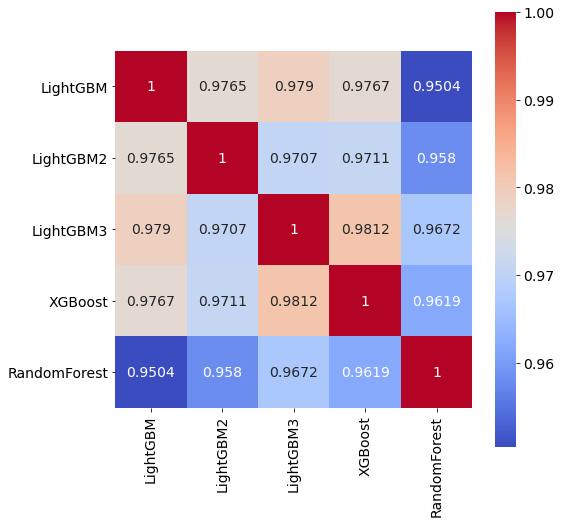

In [44]:
corr = scores.corr()

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr, annot=True, fmt='.4g', square=True, cmap='coolwarm', ax=axes)

scores.head()

#### LinearDiscriminantAnalysis

In [45]:
model_lda = LinearDiscriminantAnalysis(
    solver='eigen',
    shrinkage='auto',
    store_covariance=True,
    n_components=1
)

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=model_lda, 
                                                             X=scores, 
                                                             y=y, 
                                                             cv=folds)

Training fold 1, Test score: 0.96552
Training fold 2, Test score: 0.96418
Training fold 3, Test score: 0.96570
Training fold 4, Test score: 0.97271
Training fold 5, Test score: 0.97290
Training fold 6, Test score: 0.96689
Training fold 7, Test score: 0.96726
Training fold 8, Test score: 0.97236
Training fold 9, Test score: 0.96937
Training fold 10, Test score: 0.96282
Training fold 11, Test score: 0.97035
Training fold 12, Test score: 0.96728
Test mean score: 0.96811


#### LogisticRegression

In [46]:
model_lr = LogisticRegression(C=0.05, solver='liblinear') 

estimators_lr, oof_preds_lr, mean_score = cross_validation(model=model_lr, 
                                                             X=scores, 
                                                             y=y, 
                                                             cv=folds)

Training fold 1, Test score: 0.96579
Training fold 2, Test score: 0.96527
Training fold 3, Test score: 0.96635
Training fold 4, Test score: 0.97257
Training fold 5, Test score: 0.97327
Training fold 6, Test score: 0.96738
Training fold 7, Test score: 0.96703
Training fold 8, Test score: 0.97263
Training fold 9, Test score: 0.96952
Training fold 10, Test score: 0.96340
Training fold 11, Test score: 0.97049
Training fold 12, Test score: 0.96792
Test mean score: 0.96847


#### VotingClassifier

In [47]:
model_vc = VotingClassifier(estimators=[('LogisticRegression', model_lr), ('LinearDiscriminantAnalysis', model_lda)], voting='soft')

estimators_vc, oof_preds_vc, mean_score = cross_validation(model=model_vc, 
                                                             X=scores, 
                                                             y=y, 
                                                             cv=folds)

Training fold 1, Test score: 0.96585
Training fold 2, Test score: 0.96535
Training fold 3, Test score: 0.96648
Training fold 4, Test score: 0.97275
Training fold 5, Test score: 0.97327
Training fold 6, Test score: 0.96759
Training fold 7, Test score: 0.96713
Training fold 8, Test score: 0.97272
Training fold 9, Test score: 0.96965
Training fold 10, Test score: 0.96320
Training fold 11, Test score: 0.97058
Training fold 12, Test score: 0.96809
Test mean score: 0.96855


In [48]:
# Создание датафрейма с учебными предсказаниями
train_preds = pd.DataFrame(oof_preds_lr)
train_preds = train_preds.rename({0:'TARGET'}, axis='columns')

In [49]:
# Добавление к учебным предсказаниям столбца - 'id_client'
train_preds['id_client'] = train_df['id_client']
train_preds.head()

,TARGET,id_client
0,0.03159,1847
1,0.03293,4650
2,0.03467,4770
3,0.03171,12237
4,0.03305,9988


### Result

In [50]:
test = test_df

In [51]:
# LightGBM
pred_lgb = model_lgb.predict(test)
pred_lgb2 = model_lgb2.predict(test)
pred_lgb3 = model_lgb3.predict(test)

# XGBoost
categorical_engineering(test)
pred_xgb = model_xgb.predict(test)

# RandomForest
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
test = pd.DataFrame(imputer.fit_transform(test))
test = scaler.fit_transform(test)
pred_rfr = model_rfr.predict(test)

In [52]:
test_scores = pd.DataFrame({
    'LightGBM': pred_lgb,
    'LightGBM2': pred_lgb2,
    'LightGBM3': pred_lgb3,
    'XGBoost': pred_xgb,
    'RandomForest': pred_rfr
})

,LightGBM,LightGBM2,LightGBM3,XGBoost,RandomForest
0,0.02055,0.01311,0.01645,0.01781,0.01532
1,0.01233,0.00895,0.02921,0.01017,0.18686
2,0.01765,0.01128,0.11741,0.02275,0.22869
3,0.34580,0.86073,0.57617,0.77112,0.36178
4,0.90836,0.90462,0.91235,0.94150,0.31698


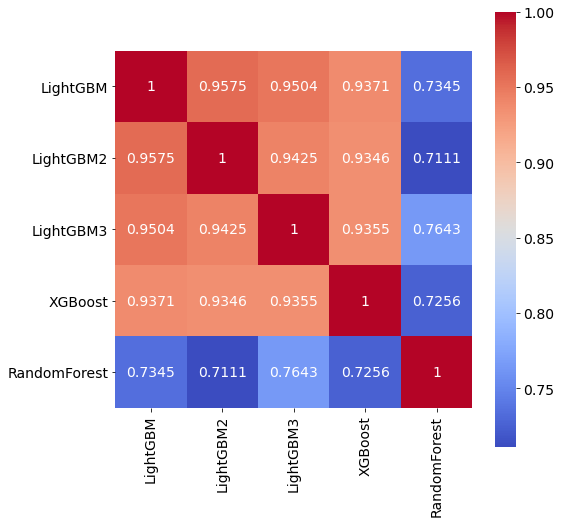

In [53]:
test_corr = test_scores.corr()

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(test_corr, annot=True, fmt='.4g', square=True, cmap='coolwarm', ax=axes)

test_scores.head()

In [54]:
# LinearDiscriminantAnalysis
prediction_lda = np.zeros(test.shape[0])
for model in estimators_lda:
    prediction_lda += model.predict_proba(test_scores)[:, 1]
prediction_lda = prediction_lda/len(estimators_lda)

In [55]:
# LogisticRegression
prediction_lr = np.zeros(test.shape[0])
for model in estimators_lr:
    prediction_lr += model.predict_proba(test_scores)[:, 1]
prediction_lr = prediction_lr/len(estimators_lr)

In [56]:
# VotingClassifier
prediction_vc = np.zeros(test.shape[0])
for model in estimators_vc:
    prediction_vc += model.predict_proba(test_scores)[:, 1]
prediction_vc = prediction_vc/len(estimators_vc)

In [57]:
# Тестовые предсказания
test = test_df
# test['TARGET'] = prediction_lda
test['TARGET'] = prediction_lr
# test['TARGET'] = prediction_vc

In [58]:
# Поиск совпадающих строк тестовых и учебных данных по полю - 'id_client'
test_target = train_preds.loc[(train_preds['id_client'].isin(test['id_client']))]
print(test_target.shape)

(6019, 2)


In [59]:
# Удаление дублирующих строк
test_target = test_target[['id_client', 'TARGET']].drop_duplicates(subset=['id_client'], keep='last')
print(test_target.shape)

(948, 2)


In [60]:
# Объединение таблиц на основе ключа - 'id_client'
test = pd.merge(test, test_target, on='id_client', how='left')

In [61]:
# Заполнение пустых строк предсказаниями
test.loc[test['TARGET_y'].isnull(), 'TARGET_y'] = test['TARGET_x']

In [62]:
# Переименование столбца
test = test.rename({'TARGET_y':'TARGET'}, axis='columns')

In [63]:
test.head()

,id_contract,id_client,IP_flag,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,F2310,F2320,F2330,F2340,F2350,F2400,F2410,F1150_LAG1,F1230_LAG1,F1510_LAG1,F1520_LAG1,F2110_LAG1,F2120_LAG1,F2200_LAG1,F2210_LAG1,F2220_LAG1,F2300_LAG1,F2320_LAG1,F2330_LAG1,F2400_LAG1,EGRPOINCLUDED,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,OKATO_REGIONCODE,OKATO_FED,OKTMO_CODE,OKTMO_FED,WORKERSRANGE,TAXREGPAY_REGDATE,COUNTCOOWNERFCSM,COUNTCOOWNERROSSTAT,COUNTCOOWNEREGRUL,COUNTBRANCH,COUNTBRANCHROSSTAT,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,DATEFIRSTREG_YEAR,TAXREG_REGDATE_YEAR,TEST_OF_TIME,THE_AMOUNT_OF_PREVIOUS_CONTRACTS,OKVED_CODE_11,OKVED_CODE_12,OKVED_CODE_21,OKVED_CODE_22,OKVED_CODE_31,KTL,BALANCE_SHEET_F1300,TARGET_x,TARGET
0,17892,3620,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47897000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,4,NaN,NaN,NaN,NaN,12,691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,485,NaN,NaN,NaN,0,NaN,10,10,10,11,9,NaN,NaN,0.03579,0.03478
1,17893,4101,0,1906000.00000,NaN,1906000.00000,NaN,NaN,NaN,NaN,14838000.00000,4392000.00000,NaN,727000.00000,NaN,9719000.00000,NaN,15222000.00000,150000.00000,NaN,NaN,NaN,15072000.00000,NaN,NaN,NaN,NaN,1522000.00000,NaN,1522000.00000,NaN,NaN,16744000.00000,16744000.00000,2998000.00000,310151000.00000,307153000.00000,2998000.00000,NaN,NaN,2998000.00000,NaN,NaN,NaN,NaN,NaN,2398000.00000,600000.00000,2722000.00000,2039000.00000,NaN,15201000.00000,326903000.00000,322811000.00000,4092000.00000,NaN,NaN,4092000.00000,NaN,NaN,3274000.00000,1.00000,4,1,2,24.00000,30.00000,24607473101.00000,30.00000,5,13,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,5.00000,2.00000,2.00000,2.00000,2.00000,0.00000,0.00000,0.00000,0.00000,7.00000,4726558.00000,0.00000,0.00000,0.00000,181.00000,0.00000,77.00000,47.00000,17883526.00000,1182.00000,14.00000,589.00000,533.00000,169299901.00000,1204.00000,2.00000,857.00000,767.00000,138194657.00000,10240.00000,69.00000,7439.00000,7100.00000,1187410724.00000,NaN,NaN,NaN,485,NaN,2010.00000,2010.00000,0,1356710625.00000,4,6,3,0,9,NaN,NaN,0.05504,0.04557
2,17894,9589,0,147000.00000,NaN,147000.00000,NaN,NaN,NaN,NaN,95529000.00000,29812000.00000,7000.00000,56538000.00000,504000.00000,8430000.00000,238000.00000,4145000.00000,2538000.00000,NaN,NaN,NaN,1607000.00000,NaN,NaN,NaN,NaN,91531000.00000,NaN,91531000.00000,NaN,NaN,95676000.00000,95676000.00000,48975000.00000,506023000.00000,457048000.00000,1753000.00000,47222000.00000,NaN,1771000.00000,NaN,NaN,NaN,726000.00000,708000.00000,1400000.00000,371000.00000,1099000.00000,122709000.00000,NaN,166904000.00000,150036000.00000,117059000.00000,1287000.00000,31690000.00000,NaN,1022000.00000,NaN,NaN,717000.00000,1.00000,4,1,2,75.00000,34.00000,75701390000.00000,34.00000,5,13,0.00000,1.00000,2.00000,0.00000,2.00000,0.00000,3.0000

In [64]:
# Сохранение результатов в файл
test[['id_contract', 'TARGET']].to_csv('submit_file.csv', sep=';', index=False)
test[['id_contract', 'TARGET']].head()

,id_contract,TARGET
0,17892,0.03478
1,17893,0.04557
2,17894,0.07088
3,17895,0.59377
4,17896,0.95186


In [65]:
test[['id_contract', 'TARGET']].tail()

,id_contract,TARGET
7325,25217,0.47499
7326,25218,0.03108
7327,25219,0.28800
7328,25220,0.33481
7329,25221,0.08525
